In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

from collections import OrderedDict

import datetime
from sys import getsizeof,path

import matplotlib.pyplot as plt
import matplotlib

path.append("../src")
from Splines import CentripetalCatmullRomSpline_splitControls,Spline
import Cases
from Population import ImportPopulation
from ModelParams import ObservedData,ModelParam

import pymc3 as pm
import theano
import theano.tensor as tt


theano.config.gcc_cxxflags = "-Wno-c++11-narrowing"

import arviz as az

In [2]:
def tt_lognormal_approx(x, mu, sigma):
# Limit to prevent NANs
    x = tt.clip(x-.5,1e-9,1e12)
    mu = tt.clip(mu,1e-12,1e12)
    sigma = tt.clip(sigma,1e-9,1e12)
    
    distr = 1/x * tt.exp( -( (tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=-1) + 1e-12)


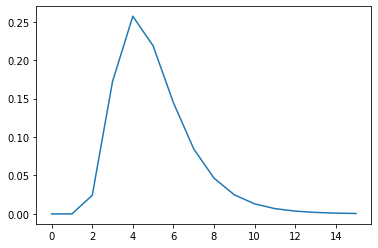

In [3]:
x = tt.shape_padleft(tt.cast(np.arange(0,16.),"float64"),1)
mu = tt.log(4.2)
sigma = .4
plt.plot(tt_lognormal_approx(x,mu,sigma).eval()[0])

In [4]:
def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12)
    mu = tt.clip(mu,1e-12,1e12)
    sigma = tt.clip(sigma,1e-9,1e12)
    
    distr = .5 * (1+tt.erf((tt.log(x)-mu)/(tt.sqrt(2.)*sigma)))
    zero = tt.shape_padright(tt.zeros_like(distr[...,-1]),1)
    residual_tail = 1.-distr[...,-1]
    return tt.concatenate([zero,distr[...,1:]-distr[...,:-1]],axis=-1)#, 1.-distr[...,-1]
    

In [6]:
tt_lognormal(x,mu,sigma).eval()

array([[0.00000000e+00, 1.66796634e-04, 3.16425000e-02, 1.68314085e-01,
        2.51335864e-01, 2.17080117e-01, 1.45180376e-01, 8.54904489e-02,
        4.71882422e-02, 2.52342856e-02, 1.33165052e-02, 7.00928687e-03,
        3.70338297e-03, 1.97158459e-03, 1.05999415e-03, 5.76266854e-04]])

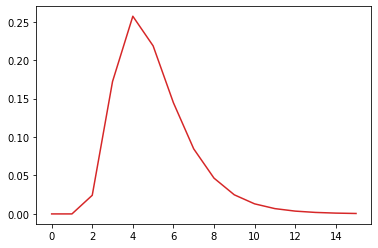

In [7]:
plt.plot(tt_lognormal_approx(x,mu,sigma).eval()[0],"tab:red")
plt.plot(tt_lognormal(x,mu,sigma)[0].eval()[0],"tab:blue")

In [8]:
print(tt.sum(tt_lognormal_approx(x,mu,sigma),axis=-1).eval()[0])
print(tt.sum(tt_lognormal(x,mu,sigma)).eval())
#print(tt_lognormal2(x,mu,sigma)[1].eval())

0.9999999999990017
0.9992697361989368
